In [1]:
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
import math
from datetime import datetime
from progressbar import progressbar

from scipy.optimize import curve_fit
import matplotlib.colors as colors
from scipy.fft import *
from scipy.interpolate import interp1d
from random import sample as random_sample

from joblib import Parallel, delayed,cpu_count


In [2]:
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 18}
import matplotlib as mpl
mpl.rc('font', **font)
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
%config InlineBackend.figure_format = 'retina'
cmap = plt.get_cmap('RdBu_r')

# Define functions

In [3]:
# Noise spectrum filter, normalized to peak of 1 
def low_pass_filter(x, x0, order):
    # print(np.sqrt(1 + np.power(np.abs(x/x0), order)))
    return 1./np.sqrt(1. + np.power(np.abs(x/x0), order)) # Low pass filter of arbitrary order, order=1 implies 1/f noise
all_pass_filter = lambda x, x0, order: 1                  # White noise

# Noise spectrum filter, normalized to peak of 1 
def decay_cos(t, A, tau,freq_rads):
    return A*np.exp(-t/tau)*np.cos(freq_rads*t)

def decay_cos_envelope(t, A, tau,freq_rads):
    return A*np.exp(-t/tau)


In [4]:
# Generate a single noisy trajectory for dephased system's frequency
def generate_noise_trajectory(sample_rate=1, t_max=200, relative_PSD_strength=(1e-3)**2, f0=1e-2, white=False):
    '''
    Provide sample rate (in us^-1), max time (in us), relative_PSD_strength (in (us^-2)/sample_rate), cutoff frequency f0 (in us^-1) and whether noise is white
    Noise will be sampled at sample_rate, generating gaussian (or 1/f filtered) frequency shifts, with std-deviation given by sqrt(relative_PSD_strength * sample_rate)
    Output is time list, a single trajectory over the time list,
              frequency list, and the effective power spectral density in this instance
    '''
    
    N = int(sample_rate*t_max) + 1       # total number of time points
    t_list = np.linspace(0, t_max, N)    # Time list
    dt = np.mean(np.diff(t_list))
    
    # First, generate a time domain trajectory that is unfiltered
    freq_shifts = np.sqrt(relative_PSD_strength * sample_rate) * np.random.normal(0.,1.,N)   # Frequency shift at each sample of time
    
    # Convert to frequency domain
    freq_y_vals = fft(freq_shifts)
    freq_x_vals = fftfreq(len(freq_shifts), d=dt)
    
    # Filter as required
    #filter x(t) rather than <x(0)x(\tau)>?
    freq_filter = all_pass_filter if white else low_pass_filter
    freq_y_vals = np.multiply(freq_y_vals, freq_filter(freq_x_vals, f0, order=1.0))
    
    
    
    # Convert back to time domain
    filtered_freq_shifts = np.real(ifft(freq_y_vals))            # Filtered freq shift at each time
    filtered_trajectory = np.cumsum(filtered_freq_shifts) * dt   # Filtered total phase shift vs time
    # Record PSD for plotting purposes
    freq_y_vals = fft(filtered_freq_shifts)
    freq_psd_vals = np.abs(freq_y_vals[:N//2])**2   # Power spectral density is positive (or negative) frequency half of FFT, squared
    
    return t_list, filtered_freq_shifts, filtered_trajectory, freq_x_vals[:N//2], freq_psd_vals

In [5]:
# Generate a bunch of trajectories and plot frequency spread and noise power spectral density
def monte_carlo_noise(num_realizations=500, sample_rate=1, t_max=200, relative_PSD_strength=(1e-3)**2, f0=1e-2, white=False):
    N = int(sample_rate*t_max) + 1                         # Total number of time points
    trajectories_list = np.zeros((num_realizations, N))    # List of trajectories
    noise_psd_list    = np.zeros((num_realizations, N//2)) # 'x//y' = int(x/y)
    
    # Simple for-loop
    trajectories_list, noise_psd_list = np.zeros((num_realizations, N)), np.zeros((num_realizations, N//2))
    for idx in range(num_realizations):
        t_list, _, traj, freq_list, psd = generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white)
        trajectories_list[idx] = traj
        noise_psd_list[idx] = psd
    
    return t_list, trajectories_list, freq_list, noise_psd_list

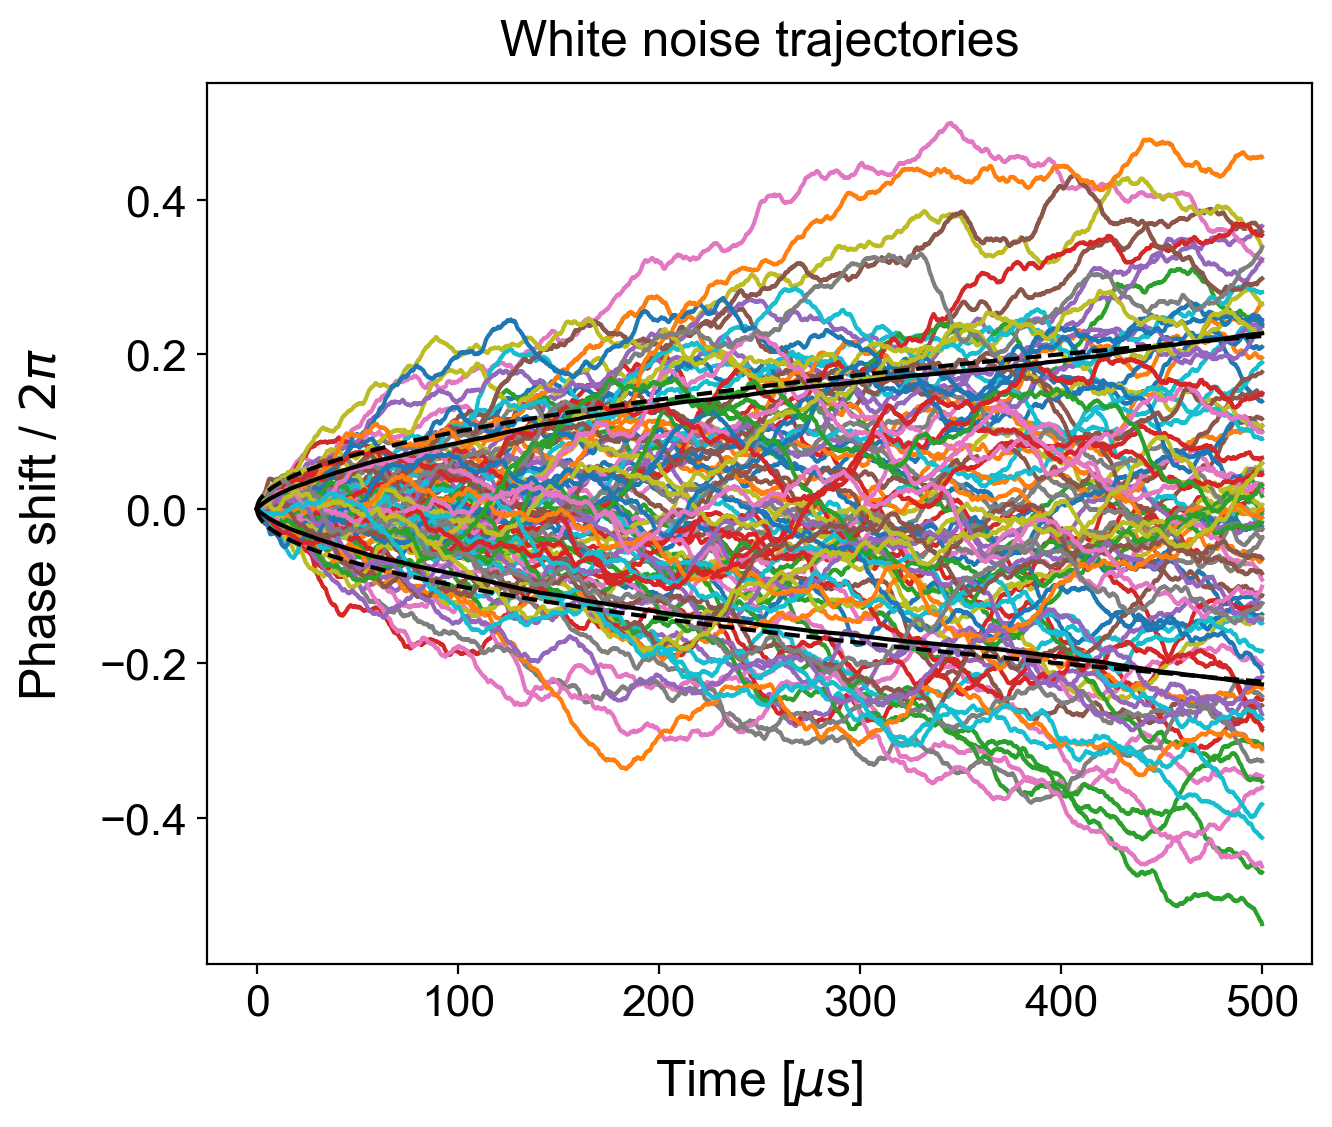

In [10]:
# Set parameters
sample_rate = 10                      # per us
t_max = 500                          # in us
relative_PSD_strength = (1e-2)**2    # sets frequency noise PSD at zero frequency, in (us^-2)/sample_rate
f0 = 1e-2                            # sets cut-off for low-pass filtered noise, in us^-1
num_realizations = 1000              # Number of Monte-Carlo trajectories
# Try white noise
t_list, trajectories_list, freq_list, white_noise_psds = monte_carlo_noise(num_realizations, sample_rate, t_max, relative_PSD_strength, f0, white=False)

white_noise_psd = np.mean(white_noise_psds, axis=0)
mean_trajectory = np.mean(trajectories_list)
std_dev_trajectory = np.std(trajectories_list, axis=0)

plt.figure(figsize=(7, 6))
for trajectory in trajectories_list[np.random.choice(len(trajectories_list), 100)]:
    plt.plot(t_list, trajectory)
    
plt.plot(t_list,  np.sqrt(t_list * relative_PSD_strength), 'k--')
plt.plot(t_list, -np.sqrt(t_list * relative_PSD_strength), 'k--')

plt.plot(t_list,  std_dev_trajectory, 'k')
plt.plot(t_list, -std_dev_trajectory, 'k')

plt.title('White noise trajectories', pad=10, size=18)
plt.xlabel(r"Time [$\mu$s]", labelpad=12)
plt.ylabel(r"Phase shift / $2\pi$", labelpad=12)
plt.tight_layout()

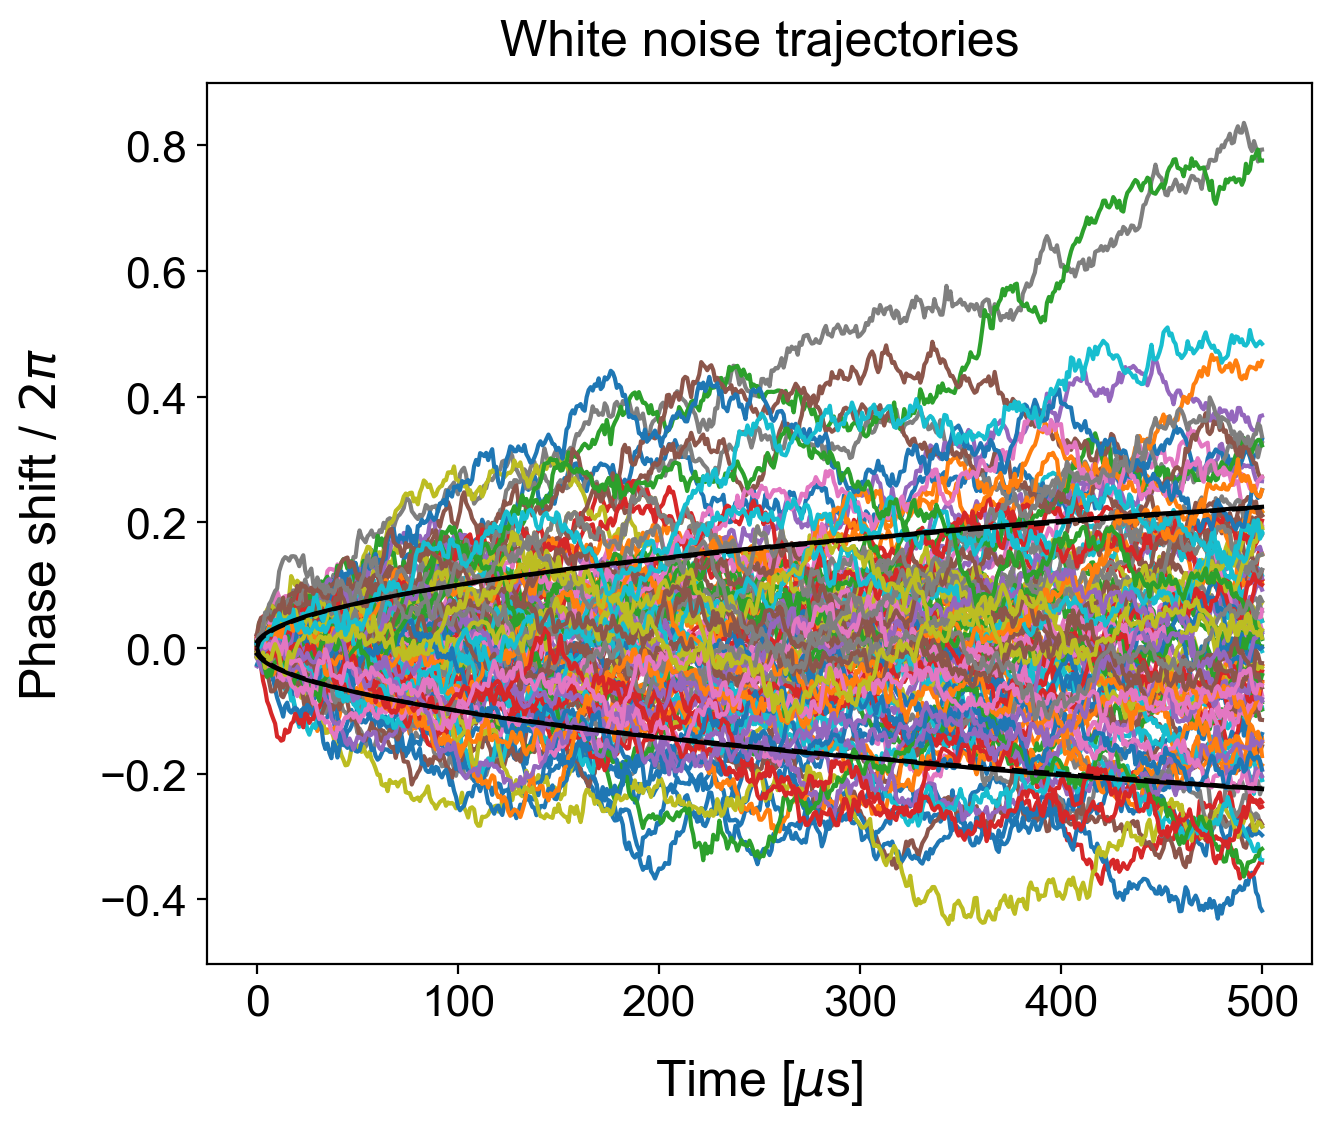

In [6]:
# Set parameters
sample_rate = 1                      # per us
t_max = 500                          # in us
relative_PSD_strength = (1e-2)**2    # sets frequency noise PSD at zero frequency, in (us^-2)/sample_rate
f0 = 1e-2                            # sets cut-off for low-pass filtered noise, in us^-1
num_realizations = 10000              # Number of Monte-Carlo trajectories
# Try white noise
t_list, trajectories_list, freq_list, white_noise_psds = monte_carlo_noise(num_realizations, sample_rate, t_max, relative_PSD_strength, f0, white=True)

white_noise_psd = np.mean(white_noise_psds, axis=0)
mean_trajectory = np.mean(trajectories_list)
std_dev_trajectory = np.std(trajectories_list, axis=0)

plt.figure(figsize=(7, 6))
for trajectory in trajectories_list[np.random.choice(len(trajectories_list), 100)]:
    plt.plot(t_list, trajectory)
    
plt.plot(t_list,  np.sqrt(t_list * relative_PSD_strength), 'k--')
plt.plot(t_list, -np.sqrt(t_list * relative_PSD_strength), 'k--')

plt.plot(t_list,  std_dev_trajectory, 'k')
plt.plot(t_list, -std_dev_trajectory, 'k')

plt.title('White noise trajectories', pad=10, size=18)
plt.xlabel(r"Time [$\mu$s]", labelpad=12)
plt.ylabel(r"Phase shift / $2\pi$", labelpad=12)
plt.tight_layout()

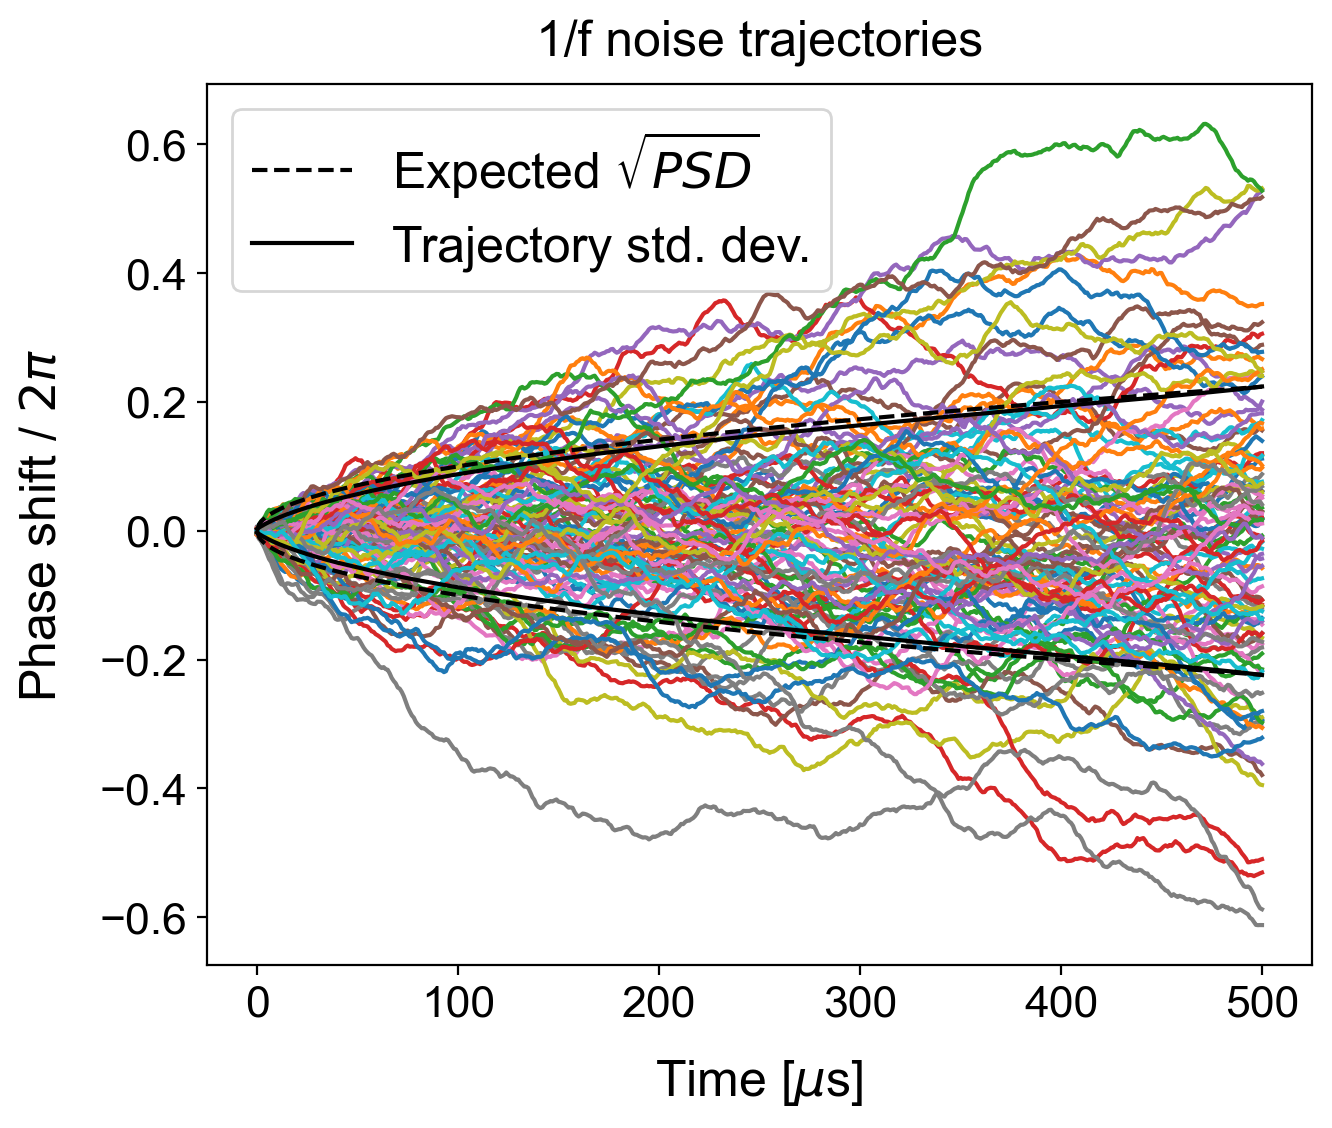

In [74]:
# Try 1/f noise
tlist, trajectories_list, freq_list, lowfreq_noise_psds = monte_carlo_noise(num_realizations, sample_rate, t_max, relative_PSD_strength, f0=1e-2, white=False)

lowfreq_noise_psd = np.mean(lowfreq_noise_psds, axis=0)
mean_trajectory = np.mean(trajectories_list)
std_dev_trajectory = np.std(trajectories_list, axis=0)

plt.figure(figsize=(7, 6))
for trajectory in trajectories_list[np.random.choice(len(trajectories_list), 100)]:
    plt.plot(tlist, trajectory)
    
plt.plot(t_list,  np.sqrt(t_list * relative_PSD_strength), 'k--', label=r'Expected $\sqrt{PSD}$')
plt.plot(t_list, -np.sqrt(t_list * relative_PSD_strength), 'k--')

plt.plot(tlist,  std_dev_trajectory, 'k', label=r'Trajectory std. dev.')
plt.plot(tlist, -std_dev_trajectory, 'k')

plt.title('1/f noise trajectories', pad=10, size=18)
plt.xlabel(r"Time [$\mu$s]", labelpad=12)
plt.ylabel(r"Phase shift / $2\pi$", labelpad=12)
plt.legend(loc='upper left')
plt.tight_layout()

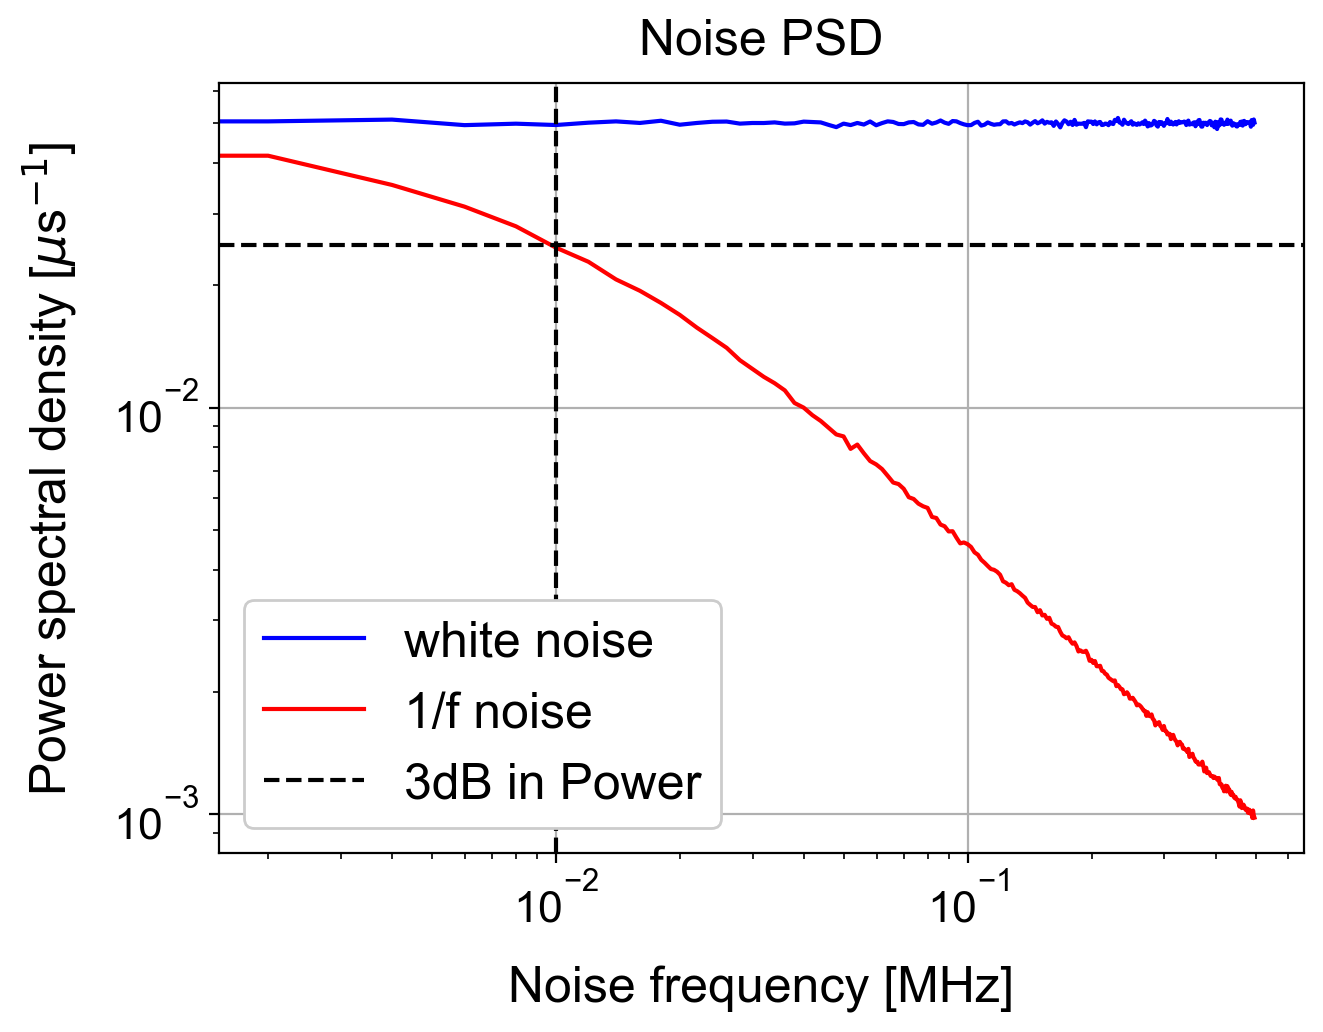

Checking definitions: 
Median PSD/ (Defined noise strength * t_max): 1.001738814108477
Std dev of frequency shifts / Square-root of (noise strength * t_max): 1.0017663762919102


In [75]:
# Plot of power spectral density
plt.figure(figsize=(7, 5))
plt.title('Noise PSD', pad=10, size=18)
plt.loglog(freq_list, white_noise_psd, 'b', label="white noise")
plt.loglog(freq_list, lowfreq_noise_psd, 'r', label="1/f noise")
plt.axvline(x = f0, color='black', linestyle='dashed') 
plt.axhline(y = lowfreq_noise_psd[0]/2, color='black', linestyle='dashed', label="3dB in Power")
plt.ylabel(r"Power spectral density [$\mu$s$^{-1}$]", labelpad=12)
plt.xlabel("Noise frequency [MHz]", labelpad=12)
plt.legend(framealpha=1.0)
plt.grid()
plt.show()

print('Checking definitions: ')
print('Median PSD/ (Defined noise strength * t_max): '+str(np.median(white_noise_psd)/(relative_PSD_strength * t_max)))
print('Std dev of frequency shifts / Square-root of (noise strength * t_max): '+str( (np.std(trajectories_list, axis=0)[-1]) / (np.sqrt(relative_PSD_strength * t_max)) ))

In [18]:
tpi = 2.*np.pi

# Generate a bunch of trajectories for qubit dephasing
def monte_carlo_qubit(detuning=0.0, num_realizations=500, sample_rate=1, t_max=200, \
                      relative_PSD_strength=(1e-3)**2, f0=1e-2, white=False, echo=False):
    N = int(sample_rate*t_max) + 1                         # Total number of time points
    trajectories_list = np.zeros((num_realizations, N))    # List of trajectories
    H0 = tpi * detuning * qt.sigmaz()                      # Detuning in us^-1
    init_state = (qt.basis(2, 0) + qt.basis(2, 1)).unit()
    
    # Go over trajectories
    Xtraj_list, noise_psd = np.zeros((num_realizations, N)), np.zeros(N//2)
    for idx in range(num_realizations):
        t_list, shifts, _, freq_list, psd = generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white)
        trajectories_list[idx] = shifts
        noise_psd += psd
        
        if echo:
            H_1 = [H0, [tpi*qt.sigmaz(), shifts[:len(t_list)//2]]]
            result = qt.sesolve(H_1, init_state, t_list[:len(t_list)//2])
            Xtraj_list[idx, :len(t_list)//2] = qt.expect(qt.sigmax(), result.states)
            halfway_state = qt.sigmax() * result.states[-1]
            H_2 = [H0, [tpi*qt.sigmaz(), shifts[len(t_list)//2+1:]]]
            result2 = qt.sesolve(H_2, halfway_state, t_list[len(t_list)//2+1:]-t_list[len(t_list)//2+1])
            Xtraj_list[idx, len(t_list)//2+1:] = qt.expect(qt.sigmax(), result2.states)
        else:
            H_tot = [H0, [tpi*qt.sigmaz(), shifts]]
            result = qt.sesolve(H_tot, init_state, t_list, e_ops=[qt.sigmax()])
            Xtraj_list[idx] = result.expect[0]
            
    noise_psd /= num_realizations
    
    return t_list, Xtraj_list, freq_list, noise_psd

In [7]:
def get_LINC_Hamiltonian_and_Noise_Term(EL_GHz,EJSum_GHz,DC_flux_symmetric_pi,Ec_MHz=100.,LINC_levels=6):
  ''' STEP 0: SET TRUNCATION ORDERS, DEVICE PARAMETERS, & DC FLUX'''

  LINC_big_trunc_order = np.amax([LINC_levels,16]) # number of levels to initially keep of the LINC

  DC_flux_symmetric = np.pi*DC_flux_symmetric_pi

  EJSum = EJSum_GHz * 2*np.pi

  EL = EL_GHz* 2*np.pi
  Ec = Ec_MHz/1000.  *2*np.pi

  ''' STEP 1: Define LINC Hamiltonian in Fock Basis'''
  a = qt.destroy(LINC_big_trunc_order)
  Nzpf = 1/np.sqrt(2)*((EL + EJSum*np.cos(DC_flux_symmetric))/(8*Ec))**(1/4)
  Theta_zpf = 1/np.sqrt(2)*((8*Ec)/(EL + EJSum*np.cos(DC_flux_symmetric)))**(1/4)

  charge_op_Fock_basis = 1j*Nzpf*(a.dag() - a)
  theta_op_Fock_basis =  Theta_zpf*(a.dag() + a)

  cos_theta_Fock_basis = theta_op_Fock_basis.cosm()
  # sin_theta_Fock_basis = theta_op_Fock_basis.sinm()

  # cos_theta_over_N_Fock_basis = (theta_op_Fock_basis/N).cosm()
  # sin_theta_over_N_Fock_basis = (theta_op_Fock_basis/N).sinm()


  H_LINC_fock_basis = (4*Ec*charge_op_Fock_basis*charge_op_Fock_basis 
                    + 1/2*EL*theta_op_Fock_basis*theta_op_Fock_basis
                    + cos_theta_Fock_basis*(
                        - EJSum*np.cos(DC_flux_symmetric)
                    )
                  )
  noise_term_fock_basis = -1.*EJSum*cos_theta_Fock_basis
  H_LINC_Energies,H_LINC_Eigenstates_Fock_basis = H_LINC_fock_basis.eigenstates() # now have energy levels of H0

  H_LINC_diaged = H_LINC_fock_basis.transform(H_LINC_Eigenstates_Fock_basis)
  noise_term_LINC_basis = noise_term_fock_basis.transform(H_LINC_Eigenstates_Fock_basis)

  H_LINC_diaged = H_LINC_diaged -  H_LINC_Energies[0]*qt.qeye(LINC_big_trunc_order)
  noise_term_LINC_basis = noise_term_LINC_basis -  noise_term_LINC_basis[0,0]*qt.qeye(LINC_big_trunc_order)

  H_LINC_diaged_trunc = qt.Qobj(H_LINC_diaged[0:LINC_levels,0:LINC_levels])
  noise_term_LINC_basis_trunc = qt.Qobj(noise_term_LINC_basis[0:LINC_levels,0:LINC_levels])
  

  return H_LINC_diaged_trunc,H_LINC_Energies,noise_term_LINC_basis_trunc 

In [8]:
tpi = 2.*np.pi

# Generate a bunch of trajectories for qubit dephasing
def monte_carlo_LINC_flux_noise(EL_GHz,EJSum_GHz,DC_flux_symmetric_pi,Ec_MHz=100.,LINC_levels=6,detuning=0.0, num_realizations=500, sample_rate=1, t_max=200, \
                      relative_PSD_strength=(1e-3)**2, f0=1e-2, white=False, echo=False,verbose=False):
    N = int(sample_rate*t_max) + 1                         # Total number of time points
    trajectories_list = np.zeros((num_realizations, N))    # List of trajectories

    H0,LINC_Energies,LINC_noise_term = get_LINC_Hamiltonian_and_Noise_Term(EL_GHz=EL_GHz,EJSum_GHz=EJSum_GHz
                ,DC_flux_symmetric_pi=DC_flux_symmetric_pi,Ec_MHz=Ec_MHz,LINC_levels=LINC_levels)

    if verbose:
        print("Noise Term")
        matrix = np.round(LINC_noise_term.full(),6)

        s = [[str(e) for e in row] for row in matrix]
        lens = [max(map(len, col)) for col in zip(*s)]
        fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
        table = [fmt.format(*row) for row in s]
        print('\n'.join(table))


        print("Static Hamiltonian Term")
        matrix = np.round(H0.full(),6)

        s = [[str(e) for e in row] for row in matrix]
        lens = [max(map(len, col)) for col in zip(*s)]
        fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
        table = [fmt.format(*row) for row in s]
        print('\n'.join(table))



    init_state = (qt.basis(LINC_levels, 0) + qt.basis(LINC_levels, 1)).unit()
    
    # Go over trajectories
    Xtraj_list, noise_psd = np.zeros((num_realizations, N)), np.zeros(N//2)
    for idx in progressbar(range(num_realizations)):
        t_list, shifts, _, freq_list, psd = generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white)
        trajectories_list[idx] = shifts
        noise_psd += psd
        
        # trajectory should be scaled since the function that couples to
        # the noise term is cos(phi_DC)cos(dPhi) - sin(phi_DC)sin(dPhi), where dPhi is some small deviation
        # Note that this is approximately just using dPhi when at the operating point, as we're linearly
        # sensitive there
        scaled_shifts = np.cos(DC_flux_symmetric_pi)*(np.cos(shifts) - 1.) - np.sin(DC_flux_symmetric_pi)*np.sin(shifts)


        # if echo:
        #     H_1 = [H0, [tpi*qt.sigmaz(), shifts[:len(t_list)//2]]]
        #     result = qt.sesolve(H_1, init_state, t_list[:len(t_list)//2])
        #     Xtraj_list[idx, :len(t_list)//2] = qt.expect(qt.sigmax(), result.states)
        #     halfway_state = qt.sigmax() * result.states[-1]
        #     H_2 = [H0, [tpi*qt.sigmaz(), shifts[len(t_list)//2+1:]]]
        #     result2 = qt.sesolve(H_2, halfway_state, t_list[len(t_list)//2+1:]-t_list[len(t_list)//2+1])
        #     Xtraj_list[idx, len(t_list)//2+1:] = qt.expect(qt.sigmax(), result2.states)
        # else:

        H_tot = [H0, [LINC_noise_term, scaled_shifts]]
        result = qt.sesolve(H_tot, init_state, t_list, e_ops=[(qt.destroy(LINC_levels) + qt.destroy(LINC_levels).dag())])
        Xtraj_list[idx] = result.expect[0]
            
    noise_psd /= num_realizations
    
    return t_list, Xtraj_list, freq_list, noise_psd

In [9]:
tpi = 2.*np.pi

# Generate a bunch of trajectories for qubit dephasing
def monte_carlo_LINC_flux_noise_rotating(EL_GHz,EJSum_GHz,DC_flux_symmetric_pi,Ec_MHz=100.,LINC_levels=6,detuning=0.0, num_realizations=500, sample_rate=1, t_max=200, \
                      relative_PSD_strength=(1e-3)**2, f0=1e-2, white=False, echo=False,verbose=False):
    N = int(sample_rate*t_max) + 1                         # Total number of time points
    trajectories_list = np.zeros((num_realizations, N))    # List of trajectories

    H0,LINC_Energies,LINC_noise_term = get_LINC_Hamiltonian_and_Noise_Term(EL_GHz=EL_GHz,EJSum_GHz=EJSum_GHz
                ,DC_flux_symmetric_pi=DC_flux_symmetric_pi,Ec_MHz=Ec_MHz,LINC_levels=LINC_levels)

    H0 = H0*0.

    if verbose:
        print("Noise Term")
        matrix = np.round(LINC_noise_term.full(),6)

        s = [[str(e) for e in row] for row in matrix]
        lens = [max(map(len, col)) for col in zip(*s)]
        fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
        table = [fmt.format(*row) for row in s]
        print('\n'.join(table))


        print("Static Hamiltonian Term")
        matrix = np.round(H0.full(),6)

        s = [[str(e) for e in row] for row in matrix]
        lens = [max(map(len, col)) for col in zip(*s)]
        fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
        table = [fmt.format(*row) for row in s]
        print('\n'.join(table))

    


    init_state = (qt.basis(LINC_levels, 0) + qt.basis(LINC_levels, 1)).unit()
    
    # Go over trajectories
    Xtraj_list, noise_psd = np.zeros((num_realizations, N)), np.zeros(N//2)
    for idx in progressbar(range(num_realizations)):
        t_list, shifts, _, freq_list, psd = generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white)
        trajectories_list[idx] = shifts
        noise_psd += psd
        
        # trajectory should be scaled since the function that couples to
        # the noise term is cos(phi_DC)(cos(dPhi) - 1) - sin(phi_DC)sin(dPhi), where dPhi is some small deviation
        # Note that this is approximately just using dPhi when at the operating point, as we're linearly
        # sensitive there
        scaled_shifts = np.cos(DC_flux_symmetric_pi)*(np.cos(shifts) - 1.) - np.sin(DC_flux_symmetric_pi)*np.sin(shifts)


        # if echo:
        #     H_1 = [H0, [tpi*qt.sigmaz(), shifts[:len(t_list)//2]]]
        #     result = qt.sesolve(H_1, init_state, t_list[:len(t_list)//2])
        #     Xtraj_list[idx, :len(t_list)//2] = qt.expect(qt.sigmax(), result.states)
        #     halfway_state = qt.sigmax() * result.states[-1]
        #     H_2 = [H0, [tpi*qt.sigmaz(), shifts[len(t_list)//2+1:]]]
        #     result2 = qt.sesolve(H_2, halfway_state, t_list[len(t_list)//2+1:]-t_list[len(t_list)//2+1])
        #     Xtraj_list[idx, len(t_list)//2+1:] = qt.expect(qt.sigmax(), result2.states)
        # else:

        H_tot = [H0, [LINC_noise_term, scaled_shifts]]
        result = qt.sesolve(H_tot, init_state, t_list, e_ops=[(qt.destroy(LINC_levels) + qt.destroy(LINC_levels).dag())])
        Xtraj_list[idx] = result.expect[0]
            
    noise_psd /= num_realizations
    
    return t_list, Xtraj_list, freq_list, noise_psd

# Testing just the noise generation functions

In [10]:
# Set parameters
sample_rate = 1                      # per us
t_max = 500                          # in us
relative_PSD_strength = (1e-2)**2    # sets frequency noise PSD at zero frequency, in (us^-2)/sample_rate
f0 = 1e-2                            # sets cut-off for low-pass filtered noise, in us^-1
num_realizations = 10000              # Number of Monte-Carlo trajectories


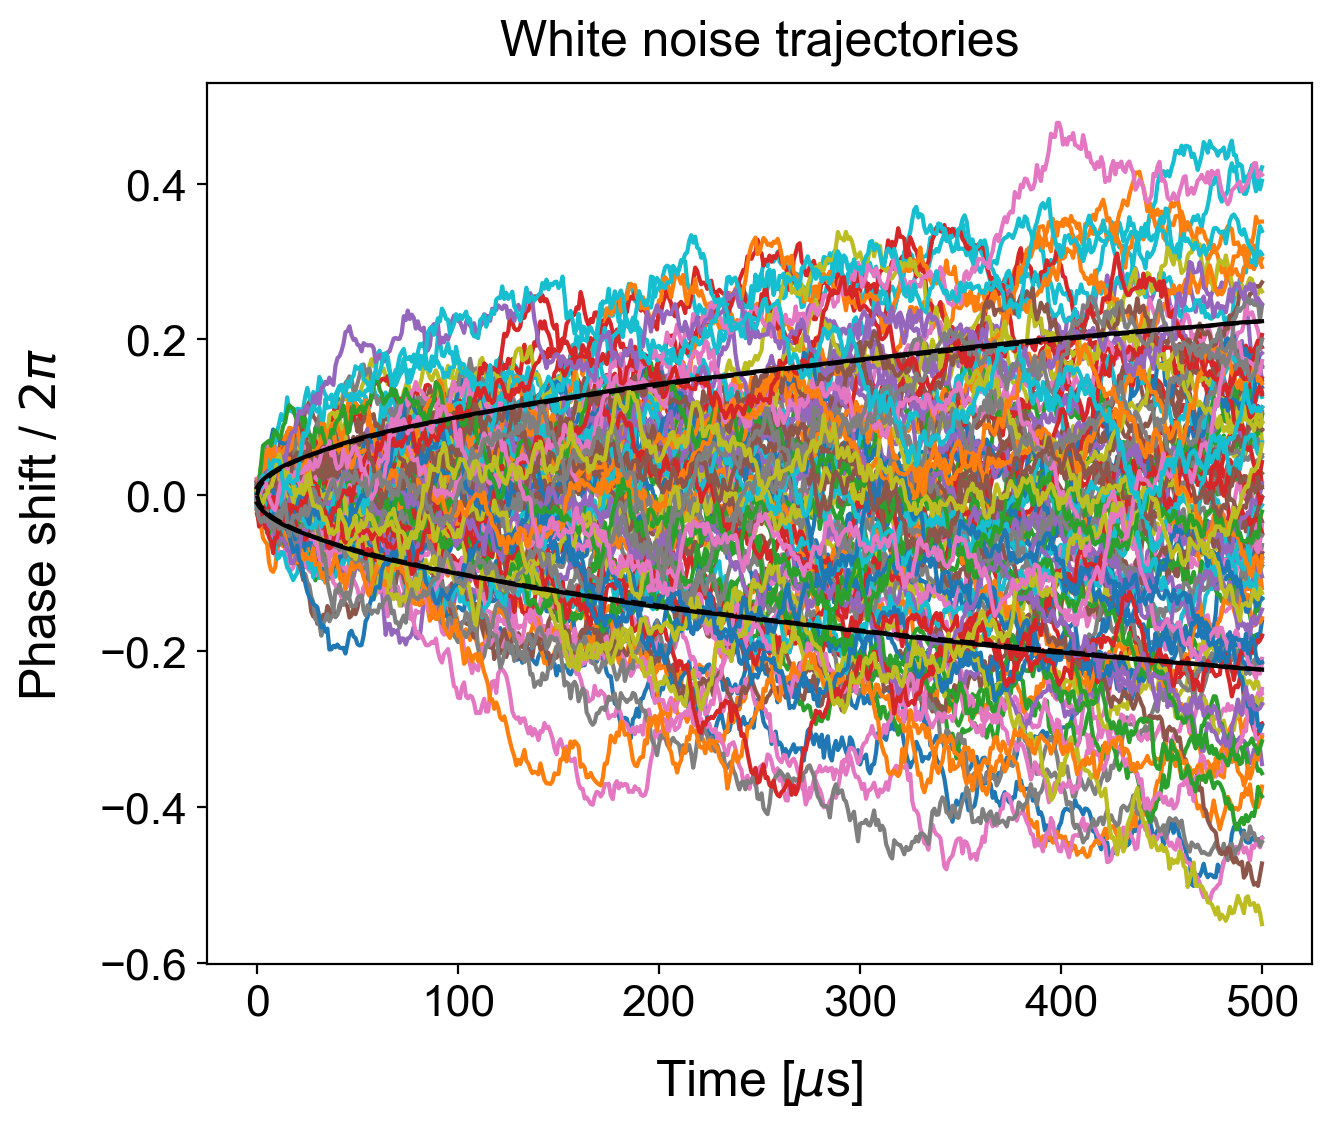

In [11]:
# Try white noise
t_list, trajectories_list, freq_list, white_noise_psd = monte_carlo_noise(num_realizations, sample_rate, t_max, relative_PSD_strength, f0, white=True)

white_noise_psd = np.mean(white_noise_psd, axis=0)
mean_trajectory = np.mean(trajectories_list)
std_dev_trajectory = np.std(trajectories_list, axis=0)

plt.figure(figsize=(7, 6))
for trajectory in trajectories_list[np.random.choice(len(trajectories_list), 100)]:
    plt.plot(t_list, trajectory)
    
plt.plot(t_list,  np.sqrt(t_list * relative_PSD_strength), 'k--')
plt.plot(t_list, -np.sqrt(t_list * relative_PSD_strength), 'k--')

plt.plot(t_list,  std_dev_trajectory, 'k')
plt.plot(t_list, -std_dev_trajectory, 'k')

plt.title('White noise trajectories', pad=10, size=18)
plt.xlabel(r"Time [$\mu$s]", labelpad=12)
plt.ylabel(r"Phase shift / $2\pi$", labelpad=12)
plt.tight_layout()

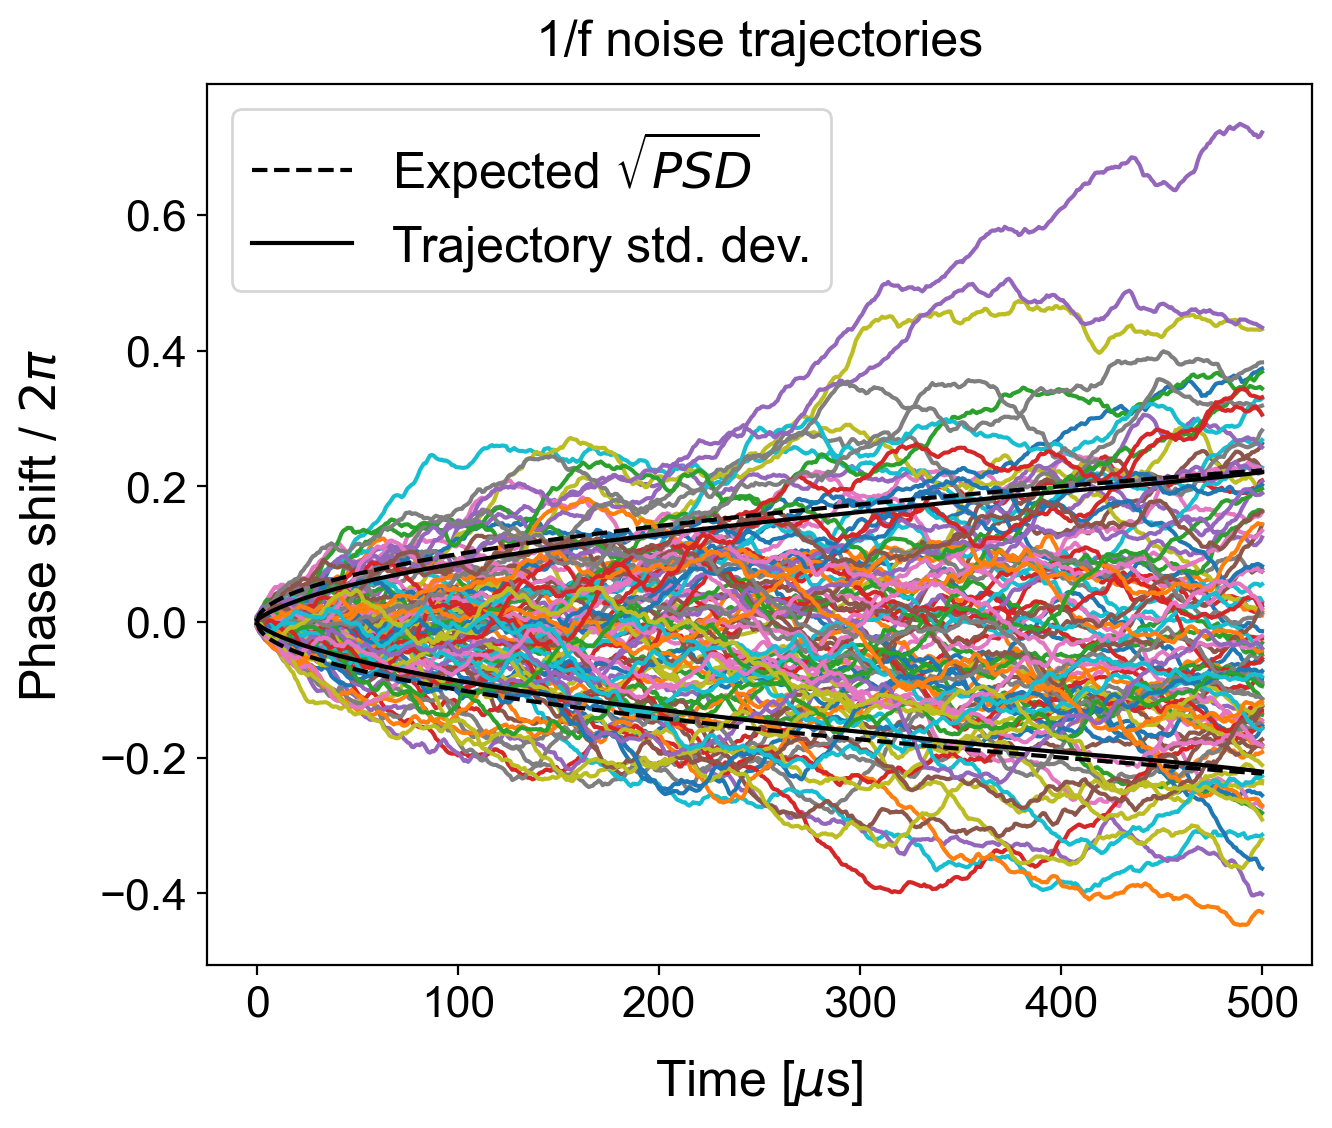

In [12]:
# Try 1/f noise
tlist, trajectories_list, freq_list, lowfreq_noise_psd = monte_carlo_noise(num_realizations, sample_rate, t_max, relative_PSD_strength, f0=1e-2, white=False)

lowfreq_noise_psd = np.mean(lowfreq_noise_psd, axis=0)
mean_trajectory = np.mean(trajectories_list)
std_dev_trajectory = np.std(trajectories_list, axis=0)

plt.figure(figsize=(7, 6))
for trajectory in trajectories_list[np.random.choice(len(trajectories_list), 100)]:
    plt.plot(tlist, trajectory)
    
plt.plot(t_list,  np.sqrt(t_list * relative_PSD_strength), 'k--', label=r'Expected $\sqrt{PSD}$')
plt.plot(t_list, -np.sqrt(t_list * relative_PSD_strength), 'k--')

plt.plot(tlist,  std_dev_trajectory, 'k', label=r'Trajectory std. dev.')
plt.plot(tlist, -std_dev_trajectory, 'k')

plt.title('1/f noise trajectories', pad=10, size=18)
plt.xlabel(r"Time [$\mu$s]", labelpad=12)
plt.ylabel(r"Phase shift / $2\pi$", labelpad=12)
plt.legend(loc='upper left')
plt.tight_layout()

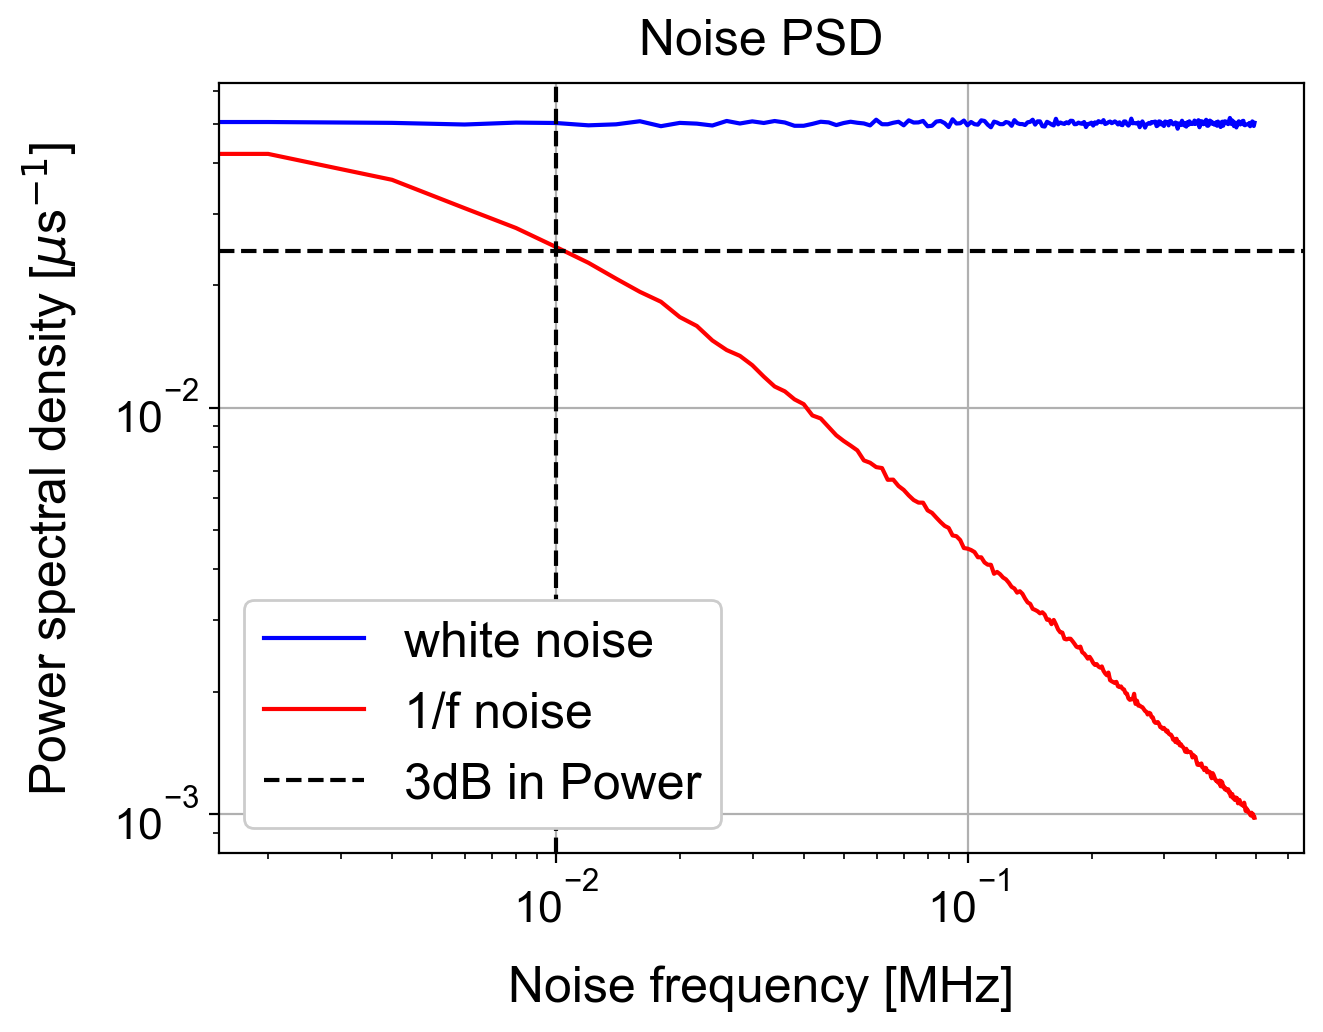

Checking definitions: 
Median PSD/ (Defined noise strength * t_max): 1.001987931957694
Std dev of frequency shifts / Square-root of (noise strength * t_max): 0.998795601170118


In [36]:
# Plot of power spectral density
plt.figure(figsize=(7, 5))
plt.title('Noise PSD', pad=10, size=18)
plt.loglog(freq_list, white_noise_psd, 'b', label="white noise")
plt.loglog(freq_list, lowfreq_noise_psd, 'r', label="1/f noise")
plt.axvline(x = f0, color='black', linestyle='dashed') 
plt.axhline(y = lowfreq_noise_psd[0]/2, color='black', linestyle='dashed', label="3dB in Power")
plt.ylabel(r"Power spectral density [$\mu$s$^{-1}$]", labelpad=12)
plt.xlabel("Noise frequency [MHz]", labelpad=12)
plt.legend(framealpha=1.0)
plt.grid()
plt.show()

print('Checking definitions: ')
print('Median PSD/ (Defined noise strength * t_max): '+str(np.median(white_noise_psd)/(relative_PSD_strength * t_max)))
print('Std dev of frequency shifts / Square-root of (noise strength * t_max): '+str( (np.std(trajectories_list, axis=0)[-1]) / (np.sqrt(relative_PSD_strength * t_max)) ))

# Testing Qubit & Echo

In [44]:
# Set parameters
sample_rate = 1                       # per us
t_max = 200                           # in us
relative_PSD_strength = (1./100.)**2  # sets frequency noise PSD at zero frequency, in (us^-2)/sample_rate
f0 = (1./100.)                        # sets cut-off for low-pass filtered noise, in us^-1
num_realizations = 1000               # Number of Monte-Carlo trajectories
detuning = 0.0                        # Ramsey detuning in units of us^-1

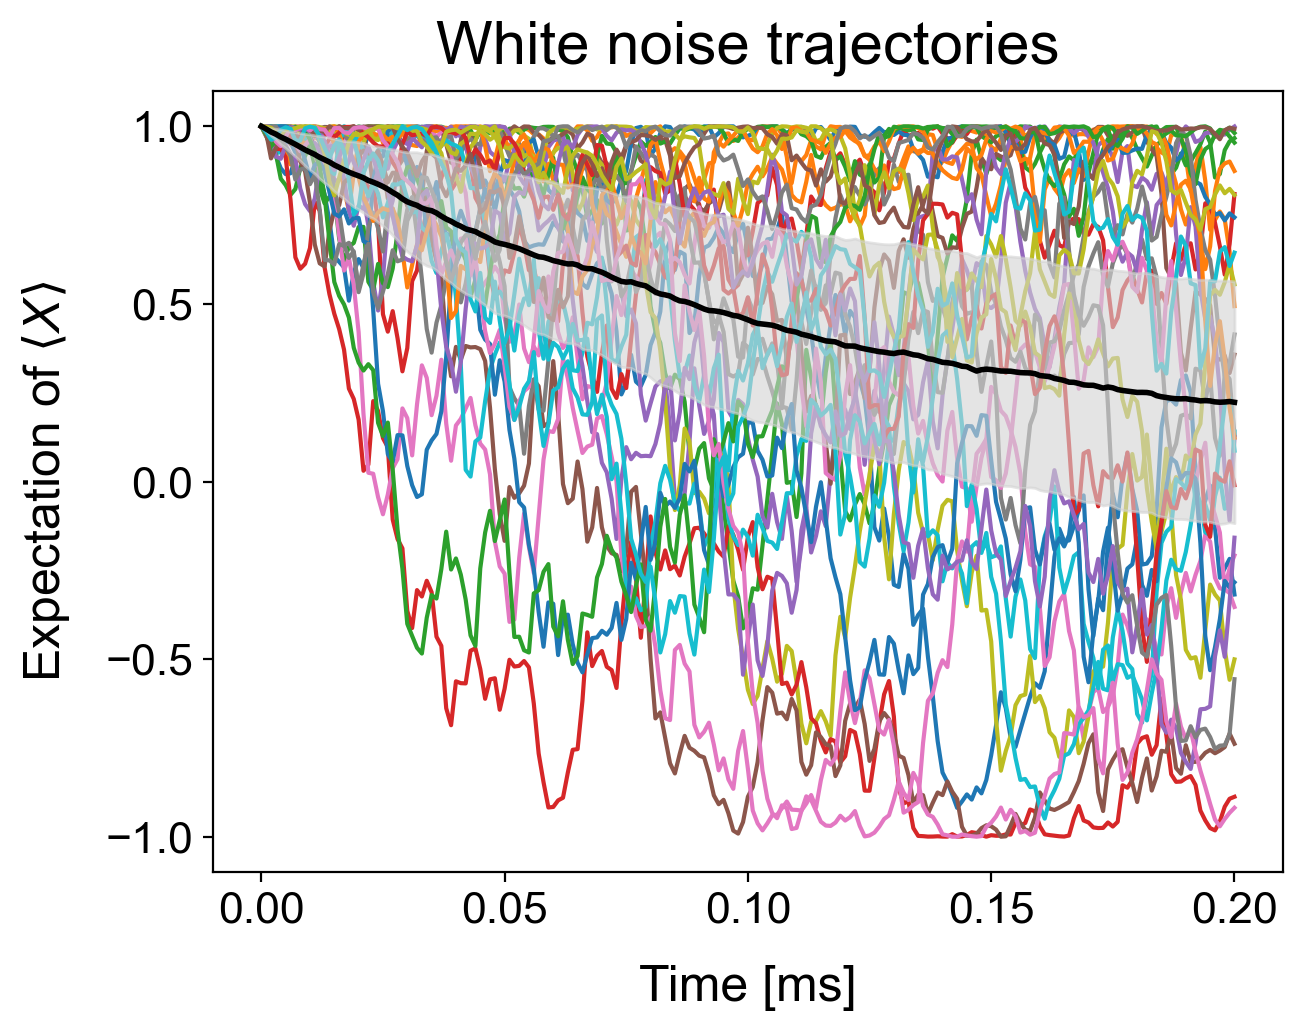

In [45]:
# Try white noise
t_list, Xtraj_list_white, freq_list, white_noise_psd = \
monte_carlo_qubit(detuning=detuning, num_realizations=num_realizations, sample_rate=sample_rate, \
                  t_max=t_max, relative_PSD_strength=relative_PSD_strength, f0=f0, white=True, echo=False)

mean_Xtraj_white = np.mean(Xtraj_list_white, axis=0)
std_dev_trajectory = np.std(Xtraj_list_white, axis=0)

plt.figure(figsize=(7, 5.5))
for trajectory in Xtraj_list_white[np.random.choice(len(Xtraj_list_white), 30)]:
    plt.plot(t_list/1e3, trajectory)

plt.fill_between(t_list/1e3, mean_Xtraj_white-std_dev_trajectory/2., mean_Xtraj_white+std_dev_trajectory/2., color='lightgrey', alpha=0.6, zorder=3)
plt.plot(t_list/1e3, mean_Xtraj_white, color='black', linewidth=2.0, zorder=4)

plt.title('White noise trajectories', pad=10)
plt.xlabel(r"Time [ms]", labelpad=12)
plt.ylabel(r"Expectation of $\langle X \rangle$", labelpad=12)
plt.tight_layout()

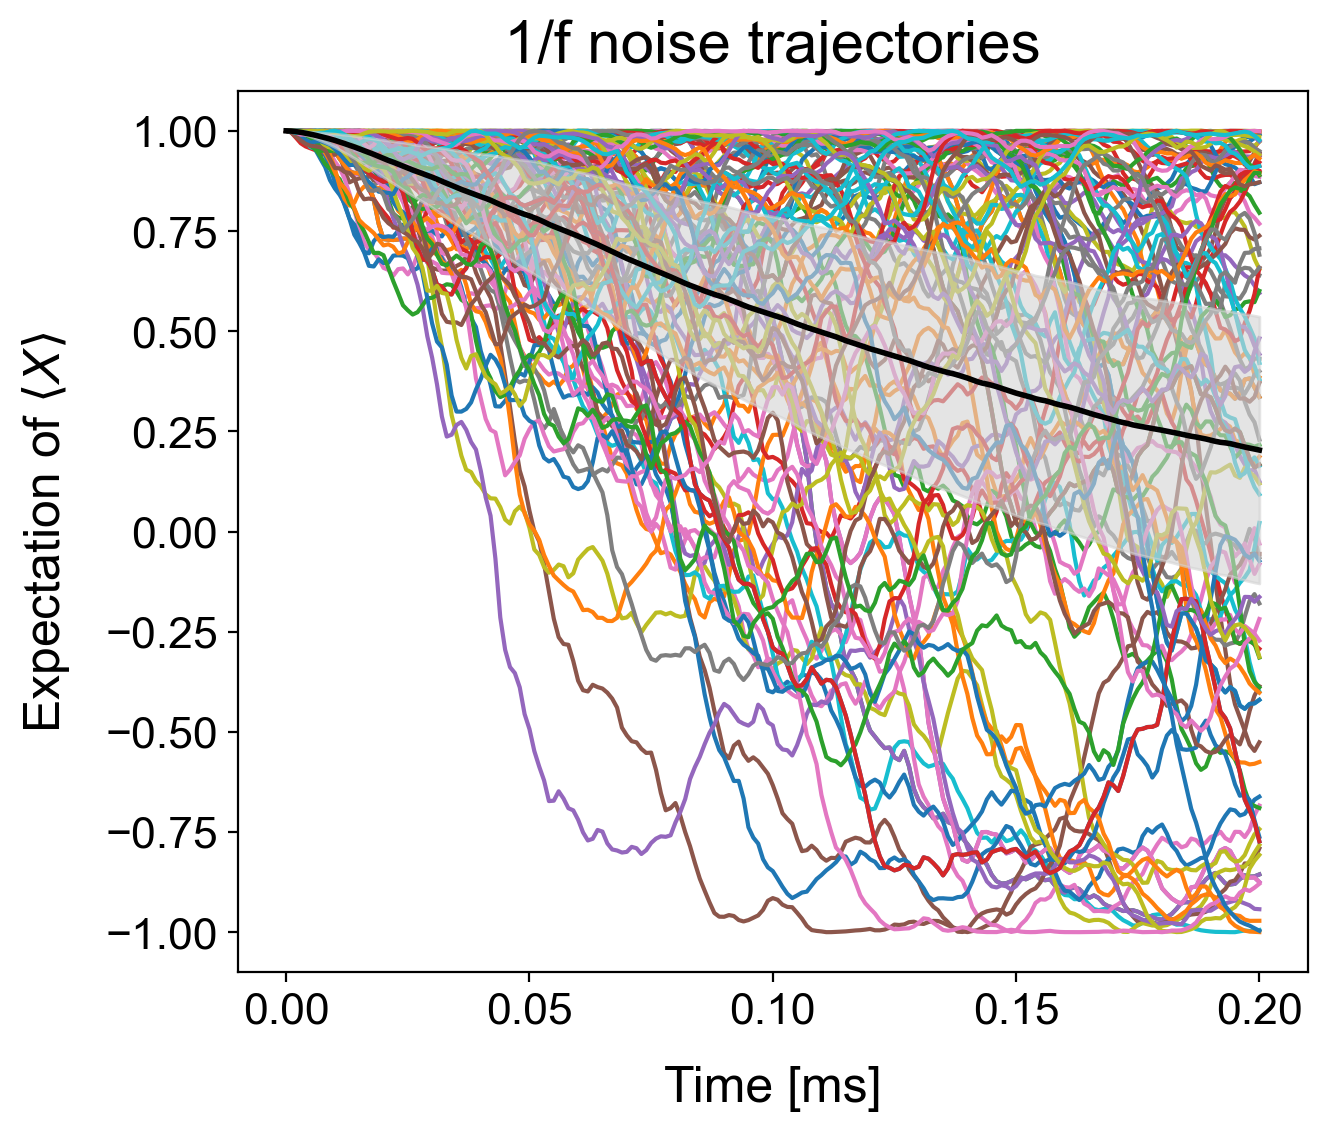

In [46]:
# Try 1/f noise
t_list, Xtraj_list_lowfreq, freq_list, lowfreq_noise_psd = \
monte_carlo_qubit(detuning=detuning, num_realizations=num_realizations, sample_rate=sample_rate, \
                  t_max=t_max, relative_PSD_strength=relative_PSD_strength, f0=f0, white=False, echo=False)

mean_Xtraj_lowfreq = np.mean(Xtraj_list_lowfreq, axis=0)
std_dev_trajectory = np.std(Xtraj_list_lowfreq, axis=0)

plt.figure(figsize=(7, 6))
for trajectory in Xtraj_list_lowfreq[np.random.choice(len(Xtraj_list_lowfreq), 100)]:
    plt.plot(t_list/1e3, trajectory)

plt.fill_between(t_list/1e3, mean_Xtraj_lowfreq-std_dev_trajectory/2., mean_Xtraj_lowfreq+std_dev_trajectory/2., color='lightgrey', alpha=0.6, zorder=3)
plt.plot(t_list/1e3, mean_Xtraj_lowfreq, color='black', linewidth=2.0, zorder=4)

plt.title('1/f noise trajectories', pad=10)
plt.xlabel(r"Time [ms]", labelpad=12)
plt.ylabel(r"Expectation of $\langle X \rangle$", labelpad=12)
plt.tight_layout()

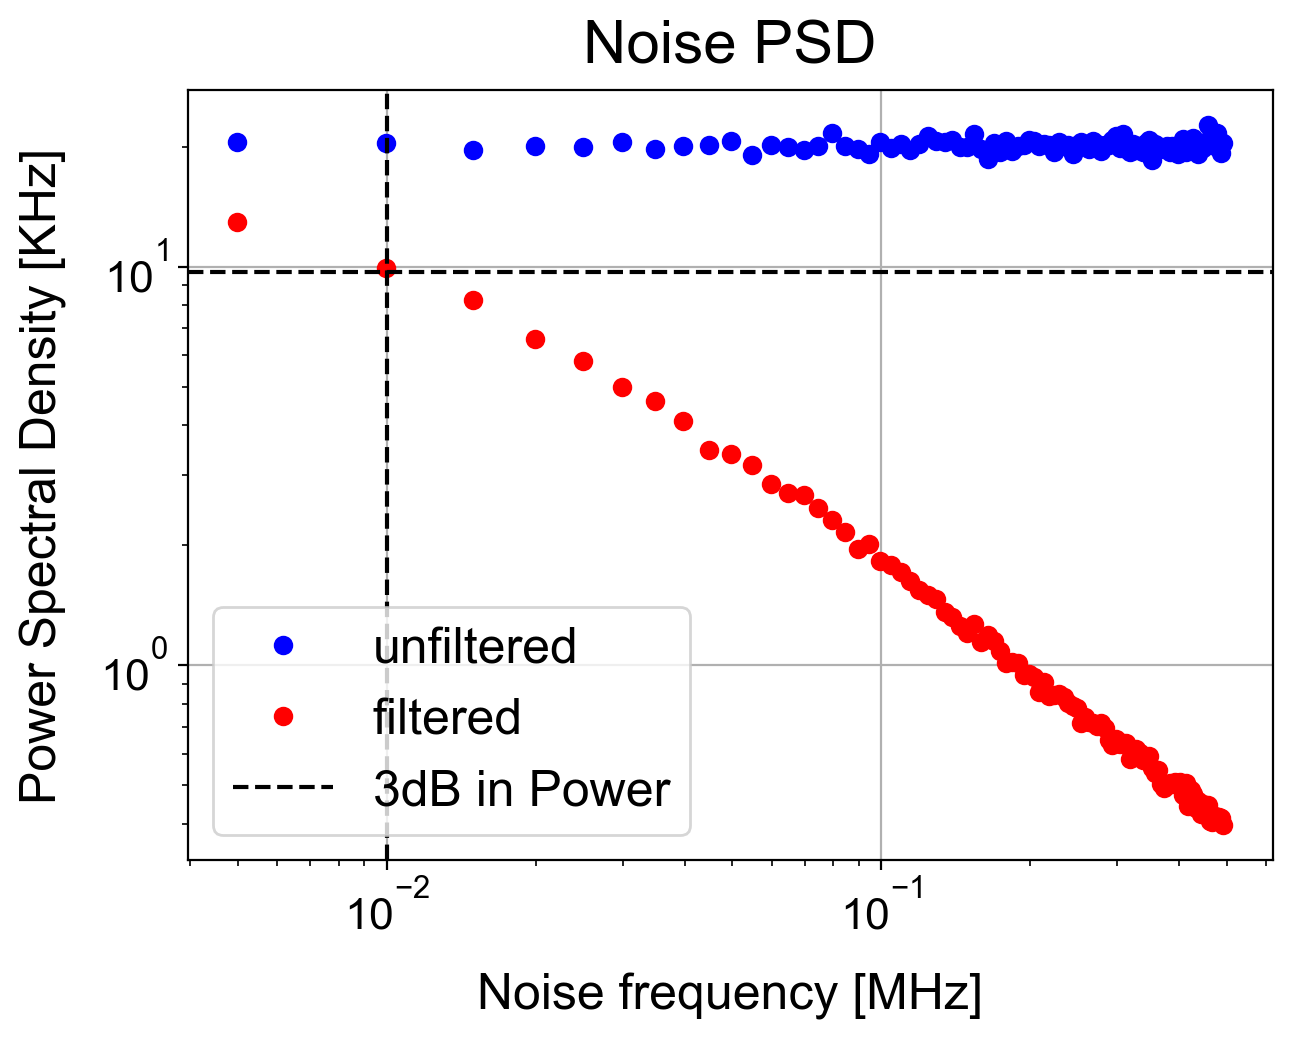

In [47]:
# Plot of power spectral density in each case
plt.figure(figsize=(7, 5))
plt.title('Noise PSD', pad=10)
plt.loglog(freq_list, white_noise_psd * 1e3, 'bo', label="unfiltered")
plt.loglog(freq_list, lowfreq_noise_psd * 1e3, 'ro', label="filtered")
plt.axvline(x = f0, color='black', linestyle='dashed')
plt.axhline(y = lowfreq_noise_psd[0]/2 * 1e3, color='black', linestyle='dashed', label="3dB in Power")
plt.ylabel("Power Spectral Density [KHz]", labelpad=12)
plt.xlabel("Noise frequency [MHz]", labelpad=12)
plt.legend()
plt.grid()
plt.show()

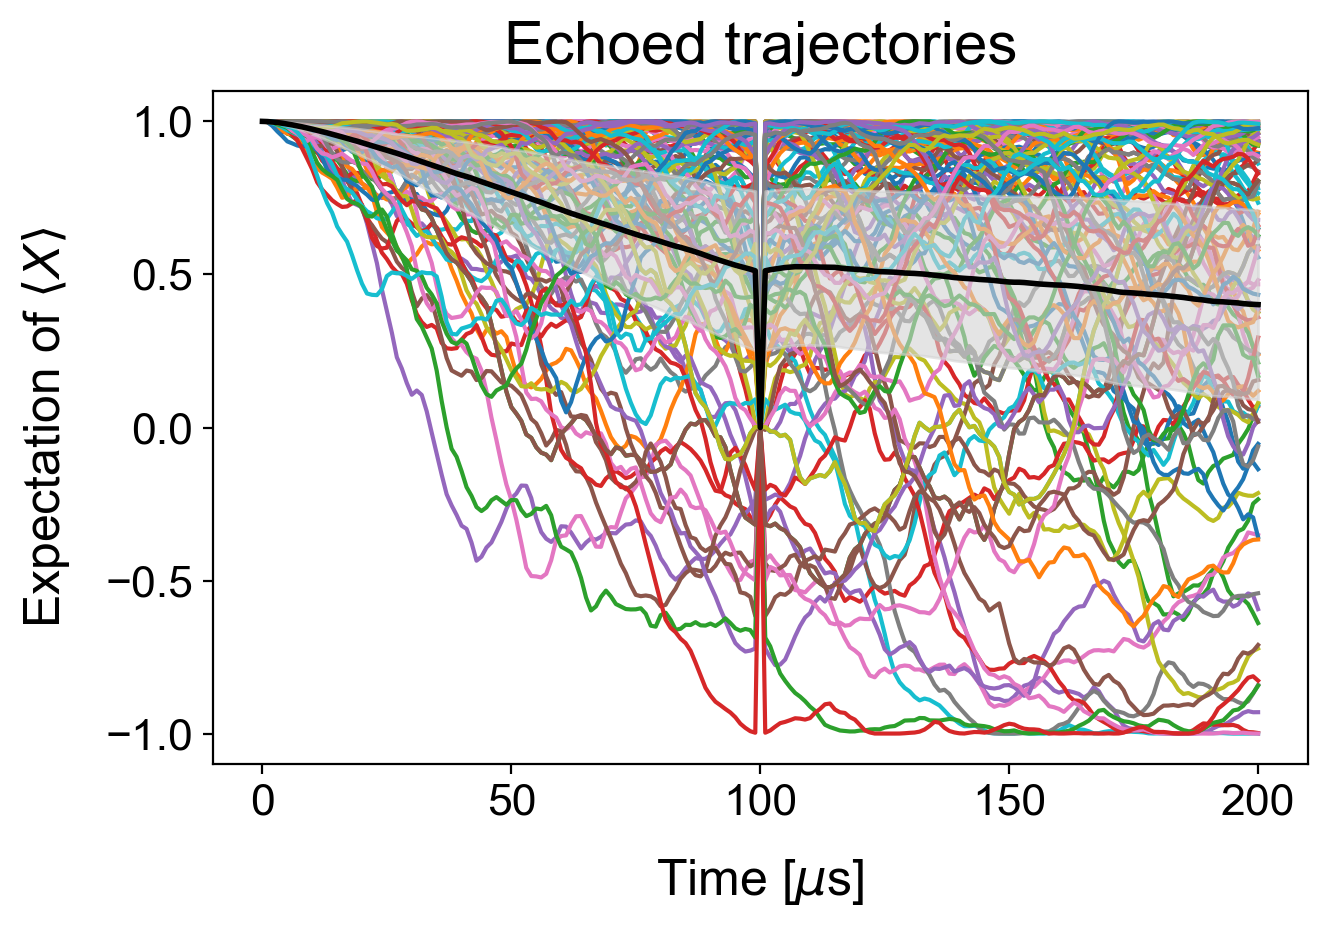

In [48]:
# Try 1/f noise, echoed
t_list, Xtraj_list_echoed, freq_list, echoed_noise_psd = \
monte_carlo_qubit(detuning=detuning, num_realizations=num_realizations, sample_rate=sample_rate, \
                  t_max=t_max, relative_PSD_strength=relative_PSD_strength, f0=f0, white=False, echo=True)

mean_Xtraj_echoed = np.mean(Xtraj_list_echoed, axis=0)
std_dev_trajectory = np.std(Xtraj_list_echoed, axis=0)

plt.figure(figsize=(7, 5))
for trajectory in Xtraj_list_echoed[np.random.choice(len(Xtraj_list_echoed), 100)]:
    plt.plot(t_list, trajectory)

plt.fill_between(t_list, mean_Xtraj_echoed-std_dev_trajectory/2., mean_Xtraj_echoed+std_dev_trajectory/2., color='lightgrey', alpha=0.6, zorder=3)
plt.plot(t_list, mean_Xtraj_echoed, color='black', linewidth=2.0, zorder=4)

# plt.ylim(0.9, 1.0)
plt.title('Echoed trajectories', pad=10)
plt.xlabel(r"Time [$\mu$s]", labelpad=12)
plt.ylabel(r"Expectation of $\langle X \rangle$", labelpad=12)
plt.tight_layout()

# Testing LINC w/ Flux Noise Case

In [407]:
# Set parameters
sample_rate = 0.5                     # per ns
t_max = 80e3                         # in ns
relative_PSD_strength = (2e-3)**2  # sets flux noise PSD at zero frequency, in (phi_0^-2)/sample_rate
f0 = (1e-6)                        # sets cut-off for low-pass filtered noise, in ns^-1
num_realizations = 81               # Number of Monte-Carlo trajectories

# LINC params

EL_GHz = 52.8
EJSum_GHz = 2*15.84
Ec_MHz = 100.
LINC_levels=2

DC_flux_symmetric_pi = 0.5

verbose = False

## White Noise

In [408]:
# Try white noise
t_list, Xtraj_list_white, freq_list, white_noise_psd = \
monte_carlo_LINC_flux_noise_rotating(EL_GHz=EL_GHz,EJSum_GHz=EJSum_GHz,DC_flux_symmetric_pi=DC_flux_symmetric_pi,Ec_MHz=Ec_MHz, num_realizations=num_realizations, sample_rate=sample_rate, \
                  t_max=t_max, relative_PSD_strength=relative_PSD_strength, f0=f0, white=True,LINC_levels=LINC_levels,verbose=verbose)


100% (81 of 81) |########################| Elapsed Time: 0:03:15 Time:  0:03:150216


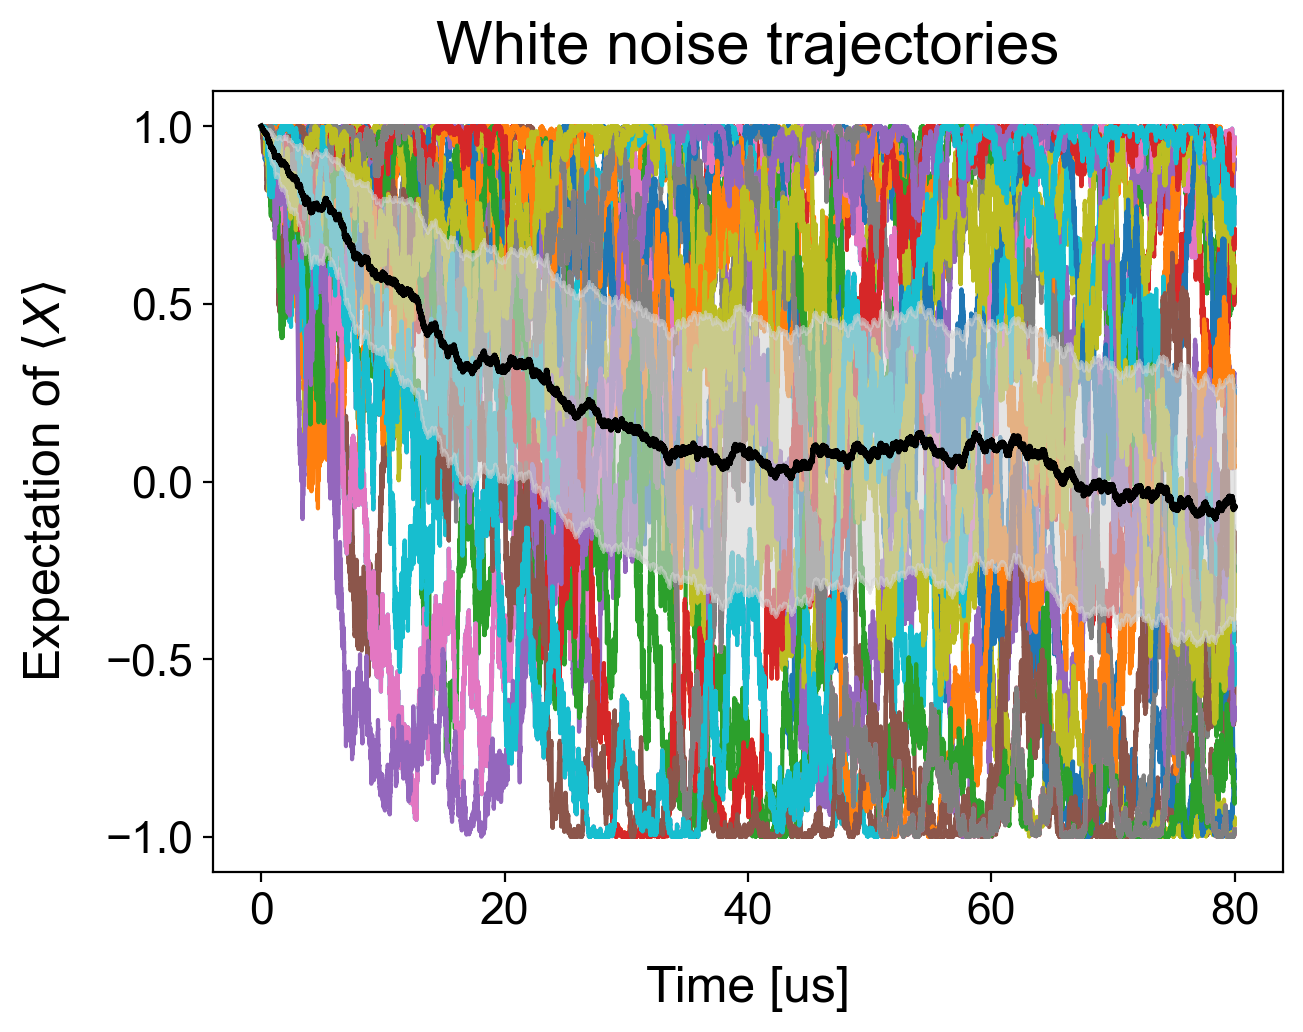

In [414]:

mean_Xtraj_white = np.mean(Xtraj_list_white, axis=0)
std_dev_trajectory = np.std(Xtraj_list_white, axis=0)

plt.figure(figsize=(7, 5.5))
for trajectory in Xtraj_list_white[np.random.choice(len(Xtraj_list_white), 30)]:
    plt.plot(t_list/1e3, trajectory)

plt.fill_between(t_list/1e3, mean_Xtraj_white-std_dev_trajectory/2., mean_Xtraj_white+std_dev_trajectory/2., color='lightgrey', alpha=0.6, zorder=3)
plt.plot(t_list/1e3, mean_Xtraj_white, color='black', linewidth=2.0, zorder=4)

plt.title('White noise trajectories', pad=10)
plt.xlabel(r"Time [us]", labelpad=12)
plt.ylabel(r"Expectation of $\langle X \rangle$", labelpad=12)
plt.tight_layout()
# plt.xlim(.05 + np.array([0,0.001]))

# tau = 250
# plt.plot(t_list/1e3,np.exp(-t_list/tau/1e3),'ro')


## 1/f Noise

In [410]:
# Try 1/f noise
t_list, Xtraj_list_lowfreq, freq_list, lowfreq_noise_psd = \
monte_carlo_LINC_flux_noise_rotating(EL_GHz=EL_GHz,EJSum_GHz=EJSum_GHz,DC_flux_symmetric_pi=DC_flux_symmetric_pi,Ec_MHz=Ec_MHz, num_realizations=num_realizations, sample_rate=sample_rate, \
                  t_max=t_max, relative_PSD_strength=relative_PSD_strength, f0=f0, white=False)

100% (81 of 81) |########################| Elapsed Time: 0:02:27 Time:  0:02:270112


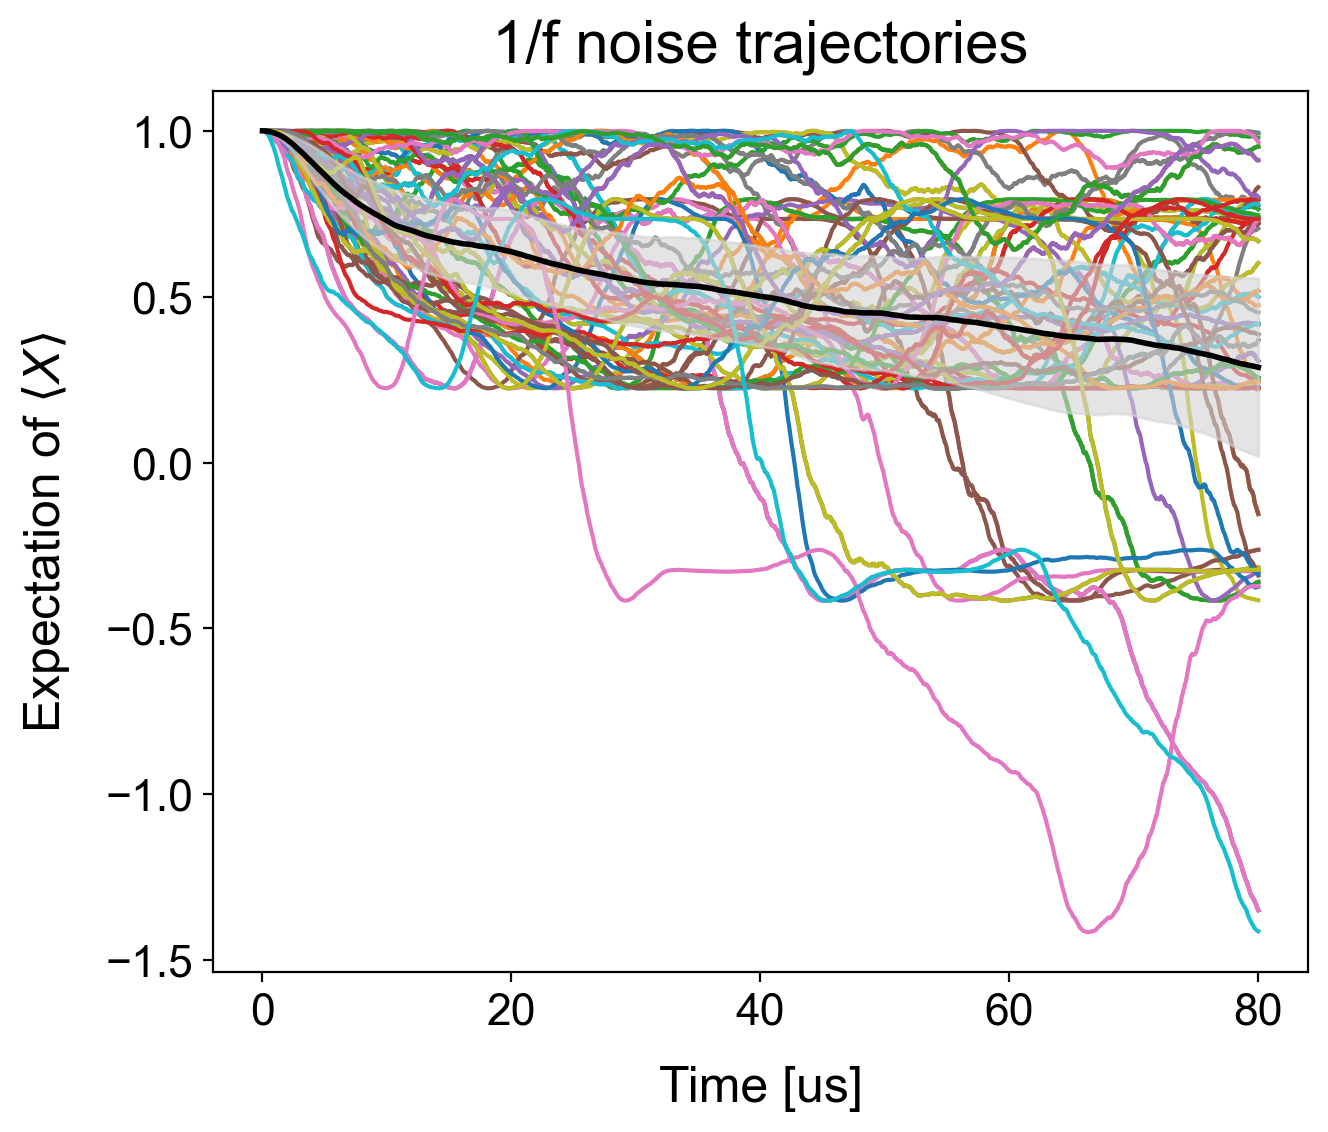

In [415]:

mean_Xtraj_lowfreq = np.mean(Xtraj_list_lowfreq, axis=0)
std_dev_trajectory = np.std(Xtraj_list_lowfreq, axis=0)

plt.figure(figsize=(7, 6))
for trajectory in Xtraj_list_lowfreq[np.random.choice(len(Xtraj_list_lowfreq), 100)]:
    plt.plot(t_list/1e3, trajectory)

plt.fill_between(t_list/1e3, mean_Xtraj_lowfreq-std_dev_trajectory/2., mean_Xtraj_lowfreq+std_dev_trajectory/2., color='lightgrey', alpha=0.6, zorder=3)
plt.plot(t_list/1e3, mean_Xtraj_lowfreq, color='black', linewidth=2.0, zorder=4)

plt.title('1/f noise trajectories', pad=10)
plt.xlabel(r"Time [us]", labelpad=12)
plt.ylabel(r"Expectation of $\langle X \rangle$", labelpad=12)
plt.tight_layout()

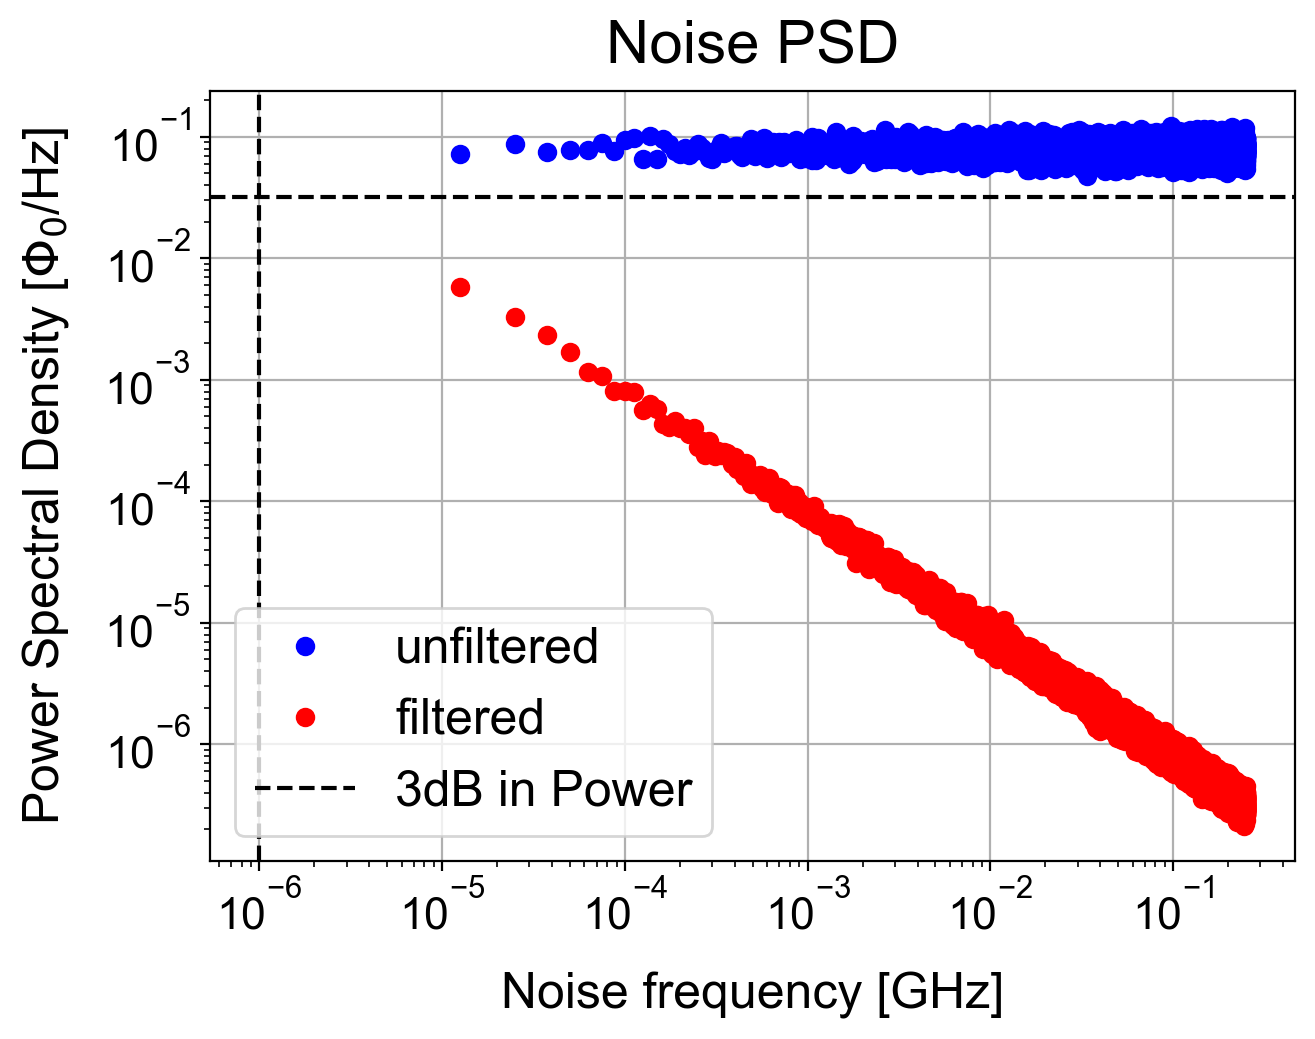

In [416]:
# Plot of power spectral density in each case
plt.figure(figsize=(7, 5))
plt.title('Noise PSD', pad=10)
plt.loglog(freq_list, white_noise_psd, 'bo', label="unfiltered")
plt.loglog(freq_list, lowfreq_noise_psd, 'ro', label="filtered")
plt.axvline(x = f0, color='black', linestyle='dashed')
plt.axhline(y = lowfreq_noise_psd[0]/2, color='black', linestyle='dashed', label="3dB in Power")
plt.ylabel(r'Power Spectral Density [$\Phi_0$/Hz]', labelpad=12)
plt.xlabel("Noise frequency [GHz]", labelpad=12)
plt.legend()
plt.grid()
plt.show()

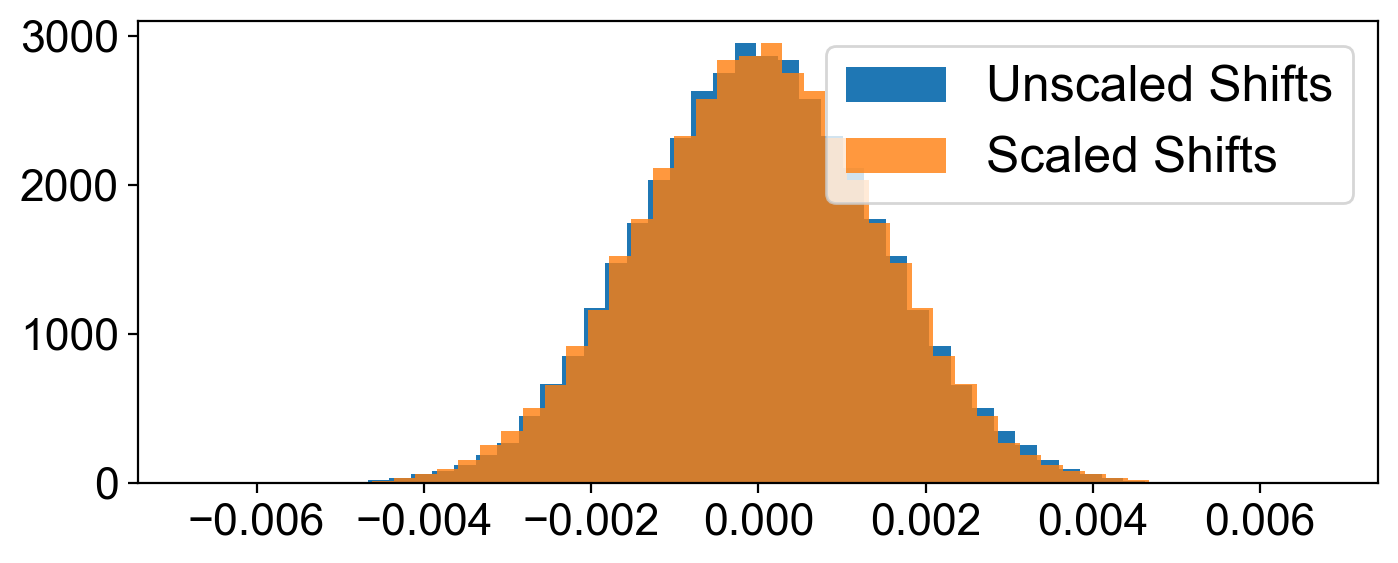

In [413]:
t_list, shifts, _, freq_list, psd = generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white=True)

# trajectory should be scaled since the function that couples to
# the noise term is cos(phi_DC)(cos(dPhi) - 1) - sin(phi_DC)sin(dPhi), where dPhi is some small deviation
# Note that this is approximately just using dPhi when at the operating point, as we're linearly
# sensitive there
scaled_shifts = np.cos(np.pi*DC_flux_symmetric_pi)*(np.cos(shifts) - 1.) - np.sin(np.pi*DC_flux_symmetric_pi)*np.sin(shifts)

plt.figure(figsize=(8,3))
plt.hist(shifts,bins=50,label="Unscaled Shifts")
plt.hist(scaled_shifts,bins=50,label="Scaled Shifts",alpha=0.8)
# print(shifts)
# print(scaled_shifts)
plt.legend()
